In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from classy import Class 
import os
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
from scipy import special
import matplotlib.cm as cm
from scipy.signal import savgol_filter

import healpy as hp
from scipy.stats import poisson

mpl.rcParams.update({
    'text.usetex': True,                  # Use LaTeX for text rendering
    'font.family': 'serif',               # Set font family to serif
    'font.serif': ['cmr10'],              # Use Computer Modern Roman for LaTeX math
    'axes.labelsize': 21,                 # Font size for axis labels
    'axes.linewidth': 1.5,                # Axis line thickness
    'xtick.labelsize': 15,                # Font size for x-tick labels
    'ytick.labelsize': 15,                # Font size for y-tick labels
    'legend.fontsize': 17,                # Font size for legend text
    'font.size': 17,
    'legend.frameon': False,              # Remove the box around the legend
    'axes.formatter.use_mathtext': True   # Use mathtext for labels
})

In [29]:
root_dir = '/output_CNB/'

m_nuL = 0.02 # in eV
Gamma = [1960.78, 980.39, 490.19]
is_ncdm_decay_degenerate = "yes" #choose between "yes" or "no"
neutrino_hierarchy = "inverted"    #choose between "normal" or "inverted"

pref = ((2 * np.pi)**3)/2 

In [31]:
eV = 1.602176487e-19
k_B = 1.3806504e-23
T_nu = 2.7255*0.71611
As = 2.0968e-09 
ns = 0.9652
k_pivot = 0.05

l_max = 17
n_kmodes = 75
Nq_interp = 100

In [32]:
k_min, k_max = 1e-4, 1e-1   # 1/Mpc
k_values = np.logspace(np.log(k_min), np.log(k_max), n_kmodes, base=np.e)

# Convert k_values to ln(k)
lnk_values = np.log(k_values)
number_string = ", ".join(f"{elem:.2e}" for elem in k_values)

print(number_string)

1.00e-04, 1.10e-04, 1.21e-04, 1.32e-04, 1.45e-04, 1.59e-04, 1.75e-04, 1.92e-04, 2.11e-04, 2.32e-04, 2.54e-04, 2.79e-04, 3.07e-04, 3.37e-04, 3.69e-04, 4.06e-04, 4.45e-04, 4.89e-04, 5.37e-04, 5.89e-04, 6.47e-04, 7.10e-04, 7.80e-04, 8.56e-04, 9.40e-04, 1.03e-03, 1.13e-03, 1.24e-03, 1.37e-03, 1.50e-03, 1.65e-03, 1.81e-03, 1.98e-03, 2.18e-03, 2.39e-03, 2.62e-03, 2.88e-03, 3.16e-03, 3.47e-03, 3.81e-03, 4.18e-03, 4.59e-03, 5.04e-03, 5.54e-03, 6.08e-03, 6.67e-03, 7.33e-03, 8.04e-03, 8.83e-03, 9.69e-03, 1.06e-02, 1.17e-02, 1.28e-02, 1.41e-02, 1.55e-02, 1.70e-02, 1.86e-02, 2.05e-02, 2.25e-02, 2.47e-02, 2.71e-02, 2.97e-02, 3.26e-02, 3.58e-02, 3.93e-02, 4.32e-02, 4.74e-02, 5.20e-02, 5.71e-02, 6.27e-02, 6.88e-02, 7.56e-02, 8.30e-02, 9.11e-02, 1.00e-01


In [33]:
def read_files(file_path, perturb_base_path, q_ratio, q_ratio2, decay = True):
    
    q_size = len(q_ratio)
    q_max = np.max(q_ratio)
    q_size2 = len(q_ratio2)

    # Read background data
    with open(file_path, 'r') as file:
        line_count = 0
        all_columns_bg = []
        for line in file:
            line_count += 1
            if line_count <= 4:  # Skip the first four lines
                continue
            columns = line.split()
            if len(all_columns_bg) == 0:
                all_columns_bg = [[] for _ in range(len(columns))]
            elif len(all_columns_bg) != len(columns):
                diff = len(columns) - len(all_columns_bg)
                all_columns_bg.extend([] for _ in range(diff))

            for j, column_data in enumerate(columns):
                all_columns_bg[j].append(float(column_data))

    # Initialize a list to store data for different wavenumber outputs
    all_columns_list = []

    # Loop over wavenumber outputs
    for i in range(n_kmodes):
        file_path = f"{perturb_base_path}_k{i}_s.dat"
        # Read only the last line of the file
        with open(file_path, 'rb') as file:
            file.seek(-2, 2)  # Move to just before the end of file
            while file.read(1) != b'\n':
                file.seek(-2, 1)  # Move back until you hit the last full line
            last_line = file.readline().decode()

        columns = last_line.split()
        all_columns = [float(value) for value in columns]                
        all_columns_list.append(all_columns)

    # Initialize lists to store perturbations
    delta = [[[None for _ in range(l_max + 1)] for _ in range(n_kmodes)] for _ in range(q_size2)]

    # Prepare f using background data
    if decay == True:
        if is_ncdm_decay_degenerate == "yes":
            lnf_all = [all_columns_bg[18 + q_size + i] for i in range(q_size)]
        else:
            lnf_all = [all_columns_bg[21 + q_size + i] for i in range(q_size)]
        lnf_s = [sublist[-1] for sublist in lnf_all]
        lnf_d = np.array(lnf_s, dtype=float)
        f = pref*np.exp(lnf_d)

    q_int = np.linspace(q_max/Nq_interp, q_max, Nq_interp)
    
    # Interpolate f
    if decay == True:
        interp_func = interp1d(q_ratio, f, kind='cubic', fill_value='extrapolate')
        f = interp_func(q_int)

    # Retrieve values for each momentum bin and multipole
    for k in range(n_kmodes):
        for q in range(q_size2):
            for l in range(l_max + 1):
                if is_ncdm_decay_degenerate == "yes":
                    delta[q][k][l] = all_columns_list[k][25 + l + (l_max+1)*q]
                else:
                    delta[q][k][l] = all_columns_list[k][29 + l + (l_max+1)*q]

    # Interpolate delta to new q-int values
    delta_interpolated = np.zeros((len(q_int), len(delta[0]), len(delta[0][0])))
    for k in range(len(delta[0])):  # Loop over k
        for l in range(len(delta[0][k])):  # Loop over l
            delta_q_k_l = [delta[q][k][l] for q in range(q_size2)]
            interp_func = interp1d(q_ratio2, delta_q_k_l, kind='cubic', fill_value='extrapolate')
            delta_q_int_k_l = interp_func(q_int)
            delta_interpolated[:, k, l] = delta_q_int_k_l

    if decay == True:
        return f, delta_interpolated, q_int
    else:
        return delta_interpolated, q_int

In [34]:
def read_Cl_CMB(file_path):
   
    l_values = []
    Cl_TT_values = []
    Cl_EE_values = []

    with open(file_path, 'r') as file:
        line_count = 0
        for line in file:
            line_count += 1
            if line_count <= 11:  # Skip the first 11 lines
                continue

            # Split the line into columns
            columns = line.split()

            # Ensure there are at least three columns to read
            if len(columns) < 3:
                raise ValueError(f"Unexpected file format: less than 3 columns in line {line_count}")

            # Append the values from the respective columns
            l_values.append(float(columns[0]))  # First column
            Cl_TT_values.append(float(columns[1]))  # Second column
            Cl_EE_values.append(float(columns[2]))  # Third column

    l_values = np.array(l_values)
    Cl_TT_values = np.array(Cl_TT_values)
    Cl_EE_values = np.array(Cl_EE_values)

    return l_values, Cl_TT_values, Cl_EE_values

In [35]:
def compute_power_spectrum(delta):
    
    # Calculate Cl values
    Cl = []
    for q in range(Nq_interp):
        integral_values = []
        for l in range(1, l_max + 1):
            integral_value = 0.0
            for k in range(len(lnk_values) - 1):
                d_lnk = lnk_values[k + 1] - lnk_values[k]
                delta_squared_midpoint = 0.5 * ( ((k_values[k]/k_pivot)**(ns-1))*delta[q][k][l]**2 + 
                                                 ((k_values[k+1]/k_pivot)**(ns-1))*delta[q][k + 1][l]**2 )  
                integral_value += delta_squared_midpoint * d_lnk
            integral_values.append(T_nu**2 * (4*np.pi) * As * integral_value)
        Cl.append(integral_values)

    Cl_1 = Cl

    # Add monopole term as 0 and shift values
    for q in range(Nq_interp):
        Cl_1[q] = np.concatenate((Cl_1[q], [0]))
        Cl_1[q] = np.roll(Cl_1[q], 1)

    return Cl_1

In [36]:
def compute_avg_hannestad(f, Cl, m_eV,q_int):
    
    dq = q_int[1]-q_int[0]
    m_class = (m_eV * eV) / (k_B * T_nu)
    eps = np.sqrt(q_int**2 + m_class**2)

    # Compute energy density integral for decaying case
    energy_d = 0.
    for q in range(Nq_interp - 1):
        en_mid = 0.5 * (q_int[q]**2 * eps[q] * f[q] + q_int[q+1]**2 * eps[q+1] * f[q+1])
        energy_d += dq * en_mid

    # Compute q-average of Cl
    Cl_avg_n = 0.
    for q in range(Nq_interp - 1):
        Cl_mid = 0.5 * (q_int[q]**2 * eps[q] * f[q] * np.sqrt(Cl[q]) + 
                        q_int[q+1]**2 * eps[q+1] * f[q+1] * np.sqrt(Cl[q+1]))
        Cl_avg_n += Cl_mid * dq

    Cl_avg_test = (Cl_avg_n/energy_d)**2
    
    return Cl_avg_test

In [37]:
def generate_poisson_fluctuations(Cl_avg0, delta_map, n_trials, N_total):
    """
    Generate Poisson-fluctuated sky maps and compute their angular power spectra.

    Parameters:
        Cl_avg0 (np.ndarray): Theoretical Cℓ spectrum (including monopole and dipole).
        delta_map (np.ndarray): Input fractional fluctuation map (δT/T).
        n_trials (int): Number of Monte Carlo realizations.
        N_total (int): Total number of neutrino capture events.

    Returns:
        maps_fluc_unscaled (np.ndarray): 2D array of unscaled fluctuated maps (δT/T).
        cls_fluc (np.ndarray): Array of angular power spectra per trial.
        ratios_fluc (list): List of Cℓ / Cℓ_theory ratios for each trial (ℓ > 0).
    """
    n_pixels = len(delta_map)
    lmax = len(Cl_avg0) - 1
    ls = np.arange(1, lmax + 1)  # Exclude monopole (ℓ=0)

    # Add monopole and convert to expected counts
    map_wmono = N_total * (delta_map + 1.95)

    # Allocate arrays
    maps_fluc_scaled = np.empty((n_trials, n_pixels), dtype=np.float64)
    maps_fluc_unscaled = np.empty((n_trials, n_pixels), dtype=np.float64)
    cls_fluc = []
    ratios_fluc = []

    rng = np.random.default_rng(seed=5)
    # Generate Poisson samples and compute Cℓs
    for i in range(n_trials):
        sampled_map = rng.poisson(map_wmono)
        maps_fluc_scaled[i] = sampled_map
        maps_fluc_unscaled[i] = (sampled_map / N_total - 1.95)

    for m in maps_fluc_unscaled:
        cl = hp.anafast(m, lmax=lmax)
        cls_fluc.append(cl[ls])
        ratios_fluc.append(cl[ls] / Cl_avg0[1:])

    return maps_fluc_scaled, maps_fluc_unscaled, np.array(cls_fluc), np.array(ratios_fluc)

In [38]:
path_Cl = root_dir+'/testB2_stable_mL0p02_cl_lensed.dat'
l0, Cl_TT0, Cl_EE0 = read_Cl_CMB(path_Cl)

path_Cl= root_dir+'/testB2_g1000_mL0p02_cl_lensed.dat'
l1, Cl_TT1, Cl_EE1 = read_Cl_CMB(path_Cl)

path_Cl= root_dir+'/testB2_g500_mL0p02_cl_lensed.dat'
l2, Cl_TT2, Cl_EE2 = read_Cl_CMB(path_Cl)

path_Cl= root_dir+'/testB2_g2000_mL0p02_cl_lensed.dat'
l3, Cl_TT3, Cl_EE3 = read_Cl_CMB(path_Cl)

In [39]:
compute_Cl_avg = False

if compute_Cl_avg:
    file_path = root_dir+'/testB2_stable_mL0p02_background.dat'
    perturb_base_path = root_dir+'/testB2_stable_mL0p02_perturbations'

    q_ratio = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]) 
    q_ratio2 = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]) 
 
    delta0, q_int0 = read_files(file_path, perturb_base_path, q_ratio, q_ratio2, decay = False)
    Cl0 = compute_power_spectrum(delta0)
    f0 = (1./(np.exp(q_int0)+1.))
    Cl_avg0 = compute_avg_hannestad(f0, Cl0, m_nuL,q_int0)
    
    np.save('./Cl_avg/Cl_avg_B2_stable_mL0p02.npy',Cl_avg0)
else:
    Cl_avg0 = np.load('./Cl_avg/Cl_avg_B2_stable_mL0p02.npy')

In [40]:
%%time

#N_total = int(1e6)
N_total = int(1e5)

n_trials = 1000

nside = 128 
delta_map = hp.synfast(Cl_avg0, nside=nside)

maps_fluc_scaled, maps_fluc_unscaled, cls_fluc, ratios_fluc = generate_poisson_fluctuations(Cl_avg0, delta_map, n_trials, N_total)

cl_mean = np.mean(cls_fluc, axis=0)
cl_std = np.std(cls_fluc, axis=0)

CPU times: user 24.2 s, sys: 5.44 s, total: 29.6 s
Wall time: 16.6 s


In [41]:
compute_Cl_avg = False

if compute_Cl_avg:
    file_path = root_dir+'/testB2_g1000_mL0p02_background.dat'
    perturb_base_path = root_dir+'/testB2_g1000_mL0p02_perturbations'

    q_ratio = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75]) 
    q_ratio2 = np.array([1,3,6,9,11,14,17,19,22,25,35,45,55,65,75]) 
 
    f1, delta1, q_int1 = read_files(file_path, perturb_base_path, q_ratio, q_ratio2, decay = True)
    Cl1 = compute_power_spectrum(delta1)
    Cl_avg1 = compute_avg_hannestad(f1, Cl1, m_nuL, q_int1)
    
    np.save('./Cl_avg/Cl_avg_B2_g1000_mL0p02.npy',Cl_avg1)
else:
    Cl_avg1 = np.load('./Cl_avg/Cl_avg_B2_g1000_mL0p02.npy')    

In [42]:
compute_Cl_avg = False

if compute_Cl_avg:
    file_path = root_dir+'/testB2_g500_mL0p02_background.dat'
    perturb_base_path = root_dir+'/testB2_g500_mL0p02_perturbations'

    q_ratio = np.array([0.958333,1.91667,2.875,3.83333,4.79167,5.75,6.70833,7.66667,8.625,9.58333,10.5417,11.5,12.4583,13.4167,14.375,15.3333,16.2917,17.25,18.2083,19.1667,20.125,21.0833,22.0417,23,23.9583,24.9167,25.875,26.8333,27.7917,28.75,29.7083,30.6667,31.625,32.5833,33.5417,34.5,35.4583,36.4167,37.375,38.3333,39.2917,40.25,41.2083,42.1667,43.125,44.0833,45.0417,46,48.625,51.25,53.875,56.5,59.125,61.75,64.375,67,69.625,72.25,74.875,77.5,80.125,82.75,85.375,88,90.625,93.25,95.875,98.5,101.125,103.75,106.375,109,111.625,114.25,116.875,119.5,122.125,124.75,127.375,130]) 
    q_ratio2 = np.array([0.958333,2.875,5.75,8.625,11.5,13.4167,16.2917,19.1667,22.0417,24.9167,35.4583,46,72.25,101.125,130]) 
 
    f2, delta2, q_int2 = read_files(file_path, perturb_base_path, q_ratio, q_ratio2, decay = True)
    Cl2 = compute_power_spectrum(delta2)
    Cl_avg2 = compute_avg_hannestad(f2, Cl2, m_nuL, q_int2)
    
    np.save('./Cl_avg/Cl_avg_B2_g500_mL0p02.npy',Cl_avg2)
else:
    Cl_avg2 = np.load('./Cl_avg/Cl_avg_B2_g500_mL0p02.npy')

In [43]:
compute_Cl_avg = False

if compute_Cl_avg:
    file_path = root_dir+'/testB2_g2000_mL0p02_background.dat'
    perturb_base_path = root_dir+'/testB2_g2000_mL0p02_perturbations'

    q_ratio = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]) 
    q_ratio2 = np.array([1,3,6,9,11,14,17,19,22,25,29,33,37,41,45]) 
 
    f3, delta3, q_int3 = read_files(file_path, perturb_base_path, q_ratio, q_ratio2, decay = True)
    Cl3 = compute_power_spectrum(delta3)
    Cl_avg3 = compute_avg_hannestad(f3, Cl3, m_nuL, q_int3)
                                 
    np.save('./Cl_avg/Cl_avg_B2_g2000_mL0p02.npy',Cl_avg3)
else:
    Cl_avg3 = np.load('./Cl_avg/Cl_avg_B2_g2000_mL0p02.npy')

In [44]:
lTT,DlTT_mean,DlTT_error_minus,DlTT_error_plus,DlTT_bestfit= np.loadtxt("error_Planck/Planck2018_errorTT.txt",unpack=True)
lEE,DlEE_mean,DlEE_error_minus,DlEE_error_plus,DlEE_bestfit= np.loadtxt("error_Planck/Planck2018_errorEE.txt",unpack=True)
lTE,DlTE_mean,DlTE_error_minus,DlTE_error_plus,DlTE_bestfit= np.loadtxt("error_Planck/Planck2018_errorTE.txt",unpack=True)

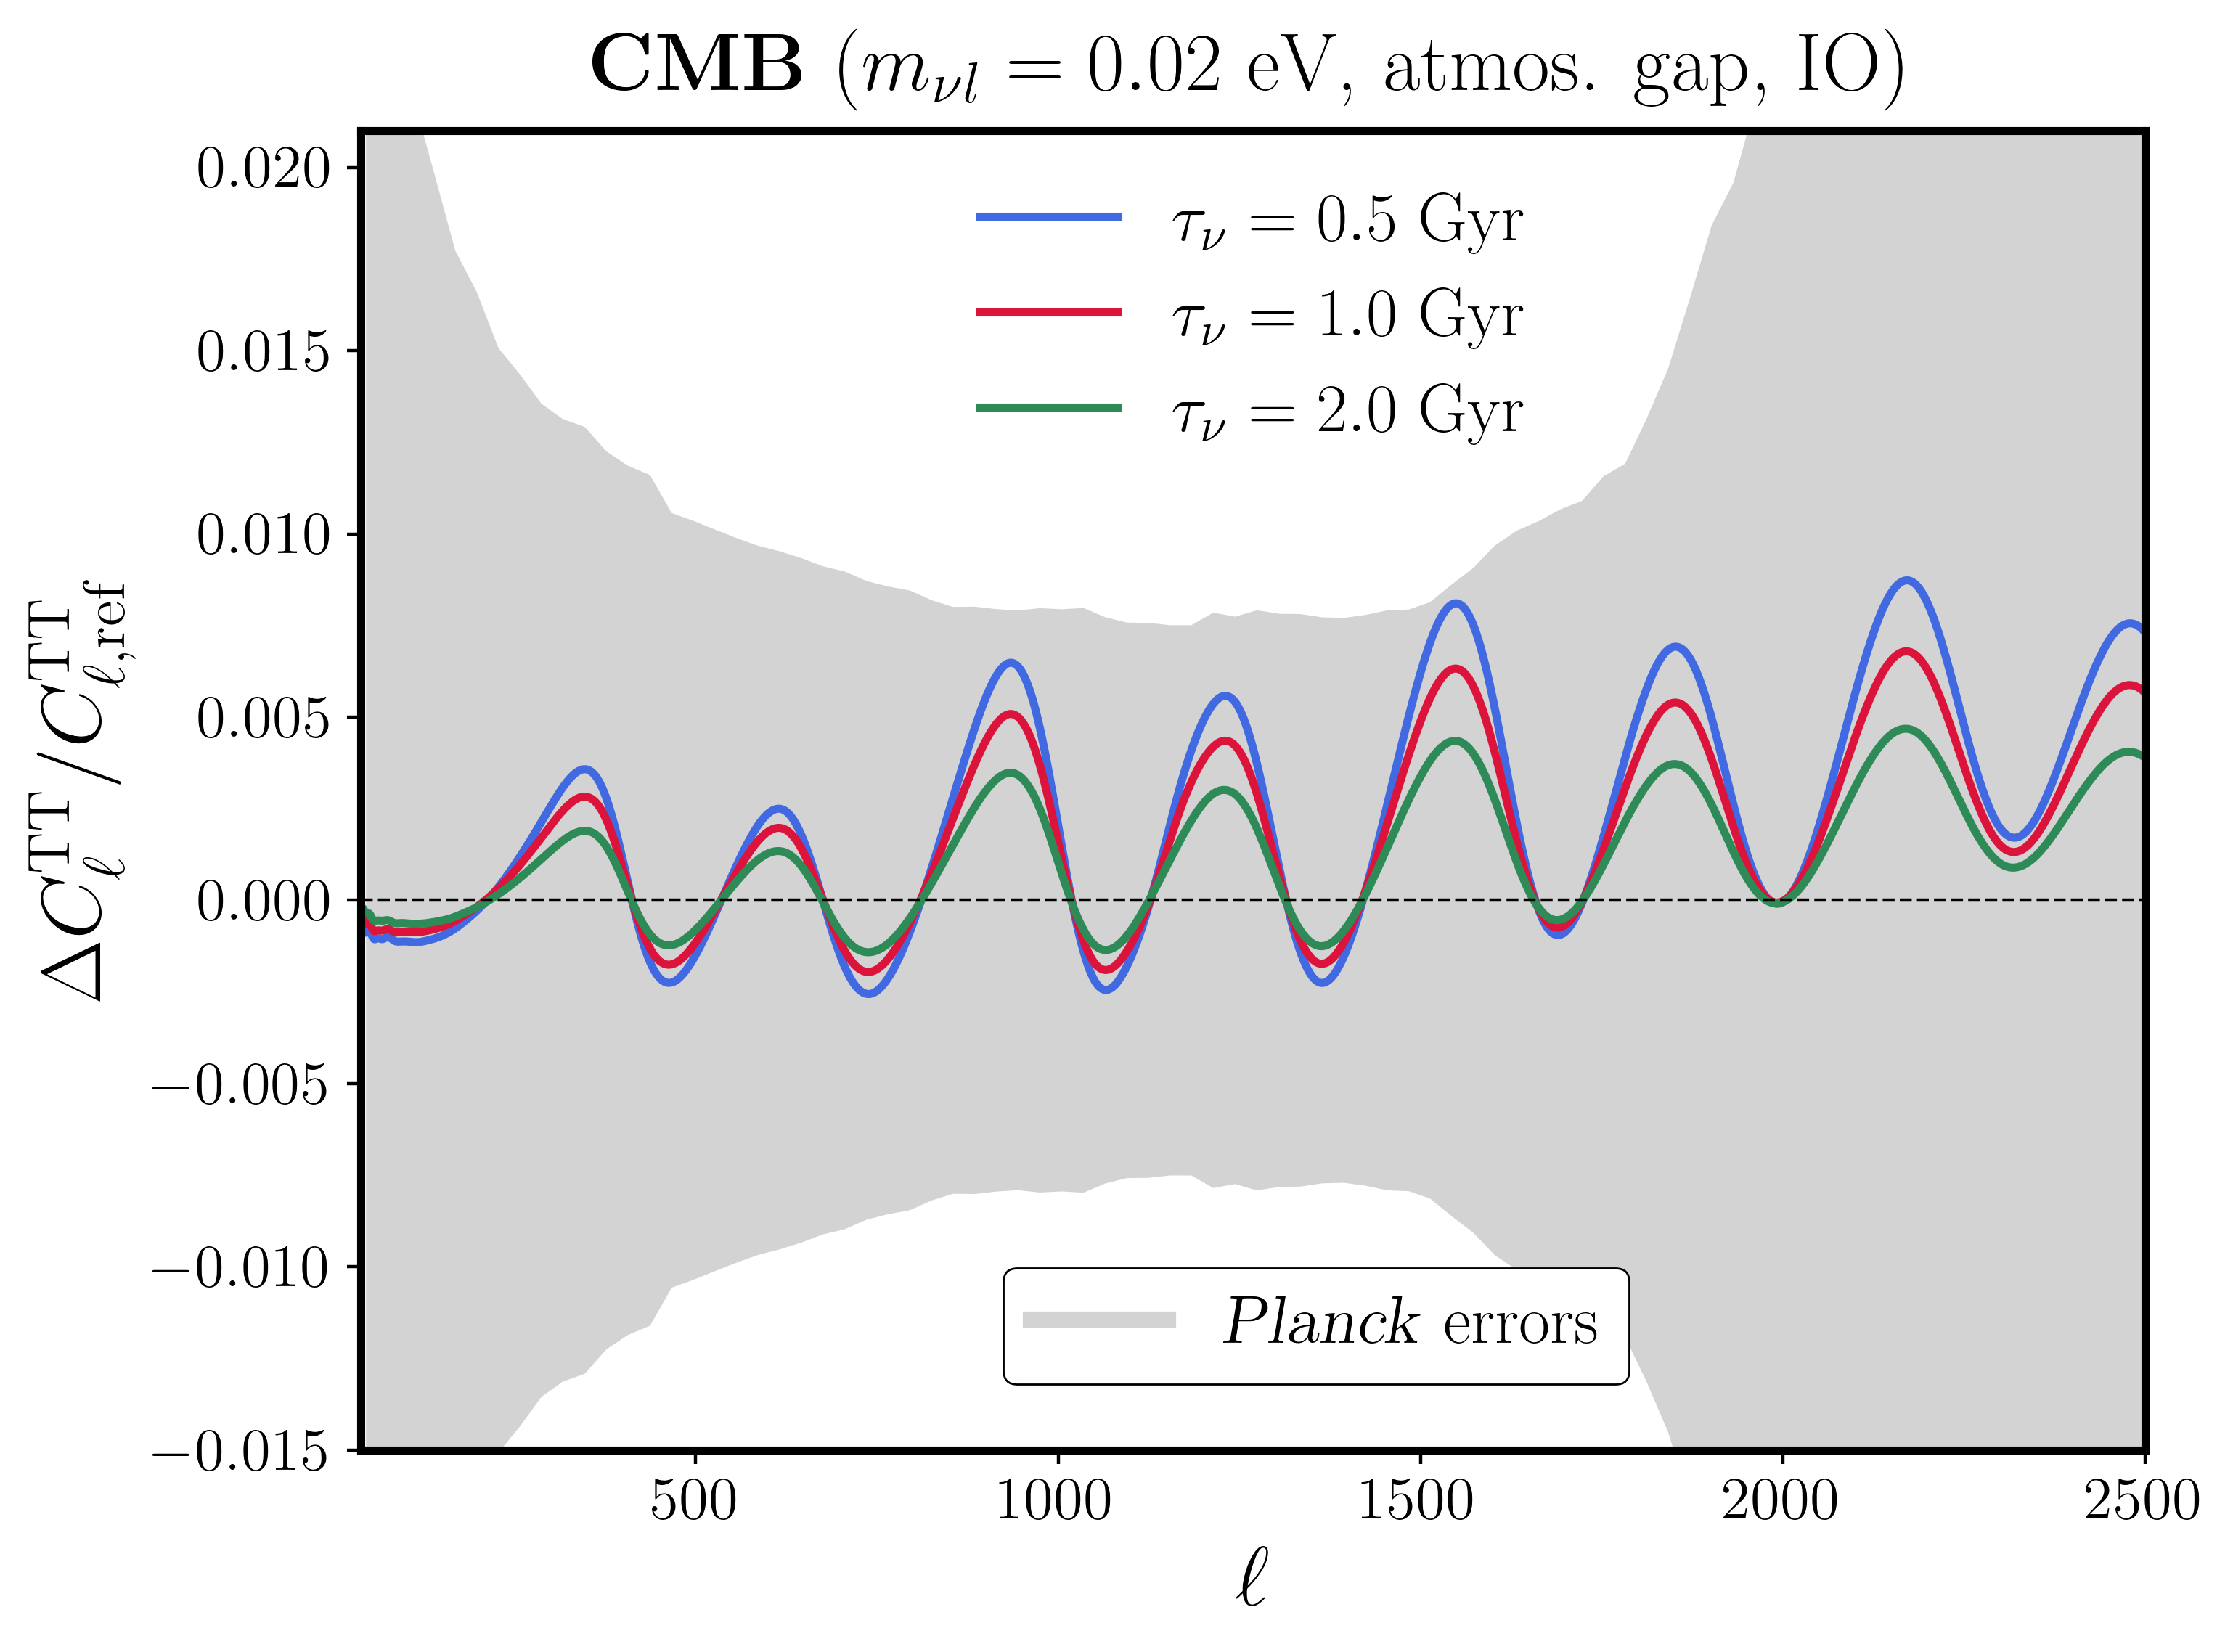

In [45]:
plt.figure(figsize=(8, 6.), dpi=400)

plt.plot(l3,(Cl_TT3-Cl_TT0)/Cl_TT0, color='royalblue', linewidth=2.0, label=r"$\tau_\nu = 0.5 \ \mathrm{Gyr}$")
plt.plot(l1,(Cl_TT1-Cl_TT0)/Cl_TT0, color='crimson',   linewidth=2.0, label=r"$\tau_\nu = 1.0 \ \mathrm{Gyr}$")
plt.plot(l2,(Cl_TT2-Cl_TT0)/Cl_TT0, color='seagreen',  linewidth=2.0, label=r"$\tau_\nu = 2.0 \ \mathrm{Gyr}$")

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

plt.fill_between(lTT, -(DlTT_error_plus)/DlTT_mean, +(DlTT_error_plus)/DlTT_mean, color='lightgray')

plt.xscale('linear')
#plt.xscale('log')
plt.yscale('linear')
plt.xlabel('$\\ell$')
plt.ylabel(r'$\Delta C_{\ell}^{\mathrm{TT}}/C_{\ell, \mathrm{ref}}^{\mathrm{TT}}$')

plt.title(r"{\bf{CMB}} ($m_{\nu l} = %.2f$ eV, atmos. gap, IO)"%m_nuL,pad=10)

plt.xlim(38, 2500)
#plt.xlim(2, 2500)

plt.ylim(-0.015, 0.021)
#plt.ylim(-0.035, 0.03)

plt.grid(False)
plt.tight_layout()

legend1 = plt.legend(frameon=False, loc='upper center')
ax = plt.gca()
ax.add_artist(legend1)

[x.set_linewidth(2.0) for x in plt.gca().spines.values()]

lines = [Line2D([0], [0], color='lightgray', linewidth=4, linestyle='-')]
labels = [r'\textsl{Planck} errors']
legend2 = plt.legend(lines, labels,loc=(0.36,0.05),frameon=True, 
           facecolor='white',edgecolor='black',framealpha=1.0)
legend2.get_frame().set_linewidth(0.5)


plt.savefig('plots_residuals/CMB_residuals_B2.pdf')

plt.show()

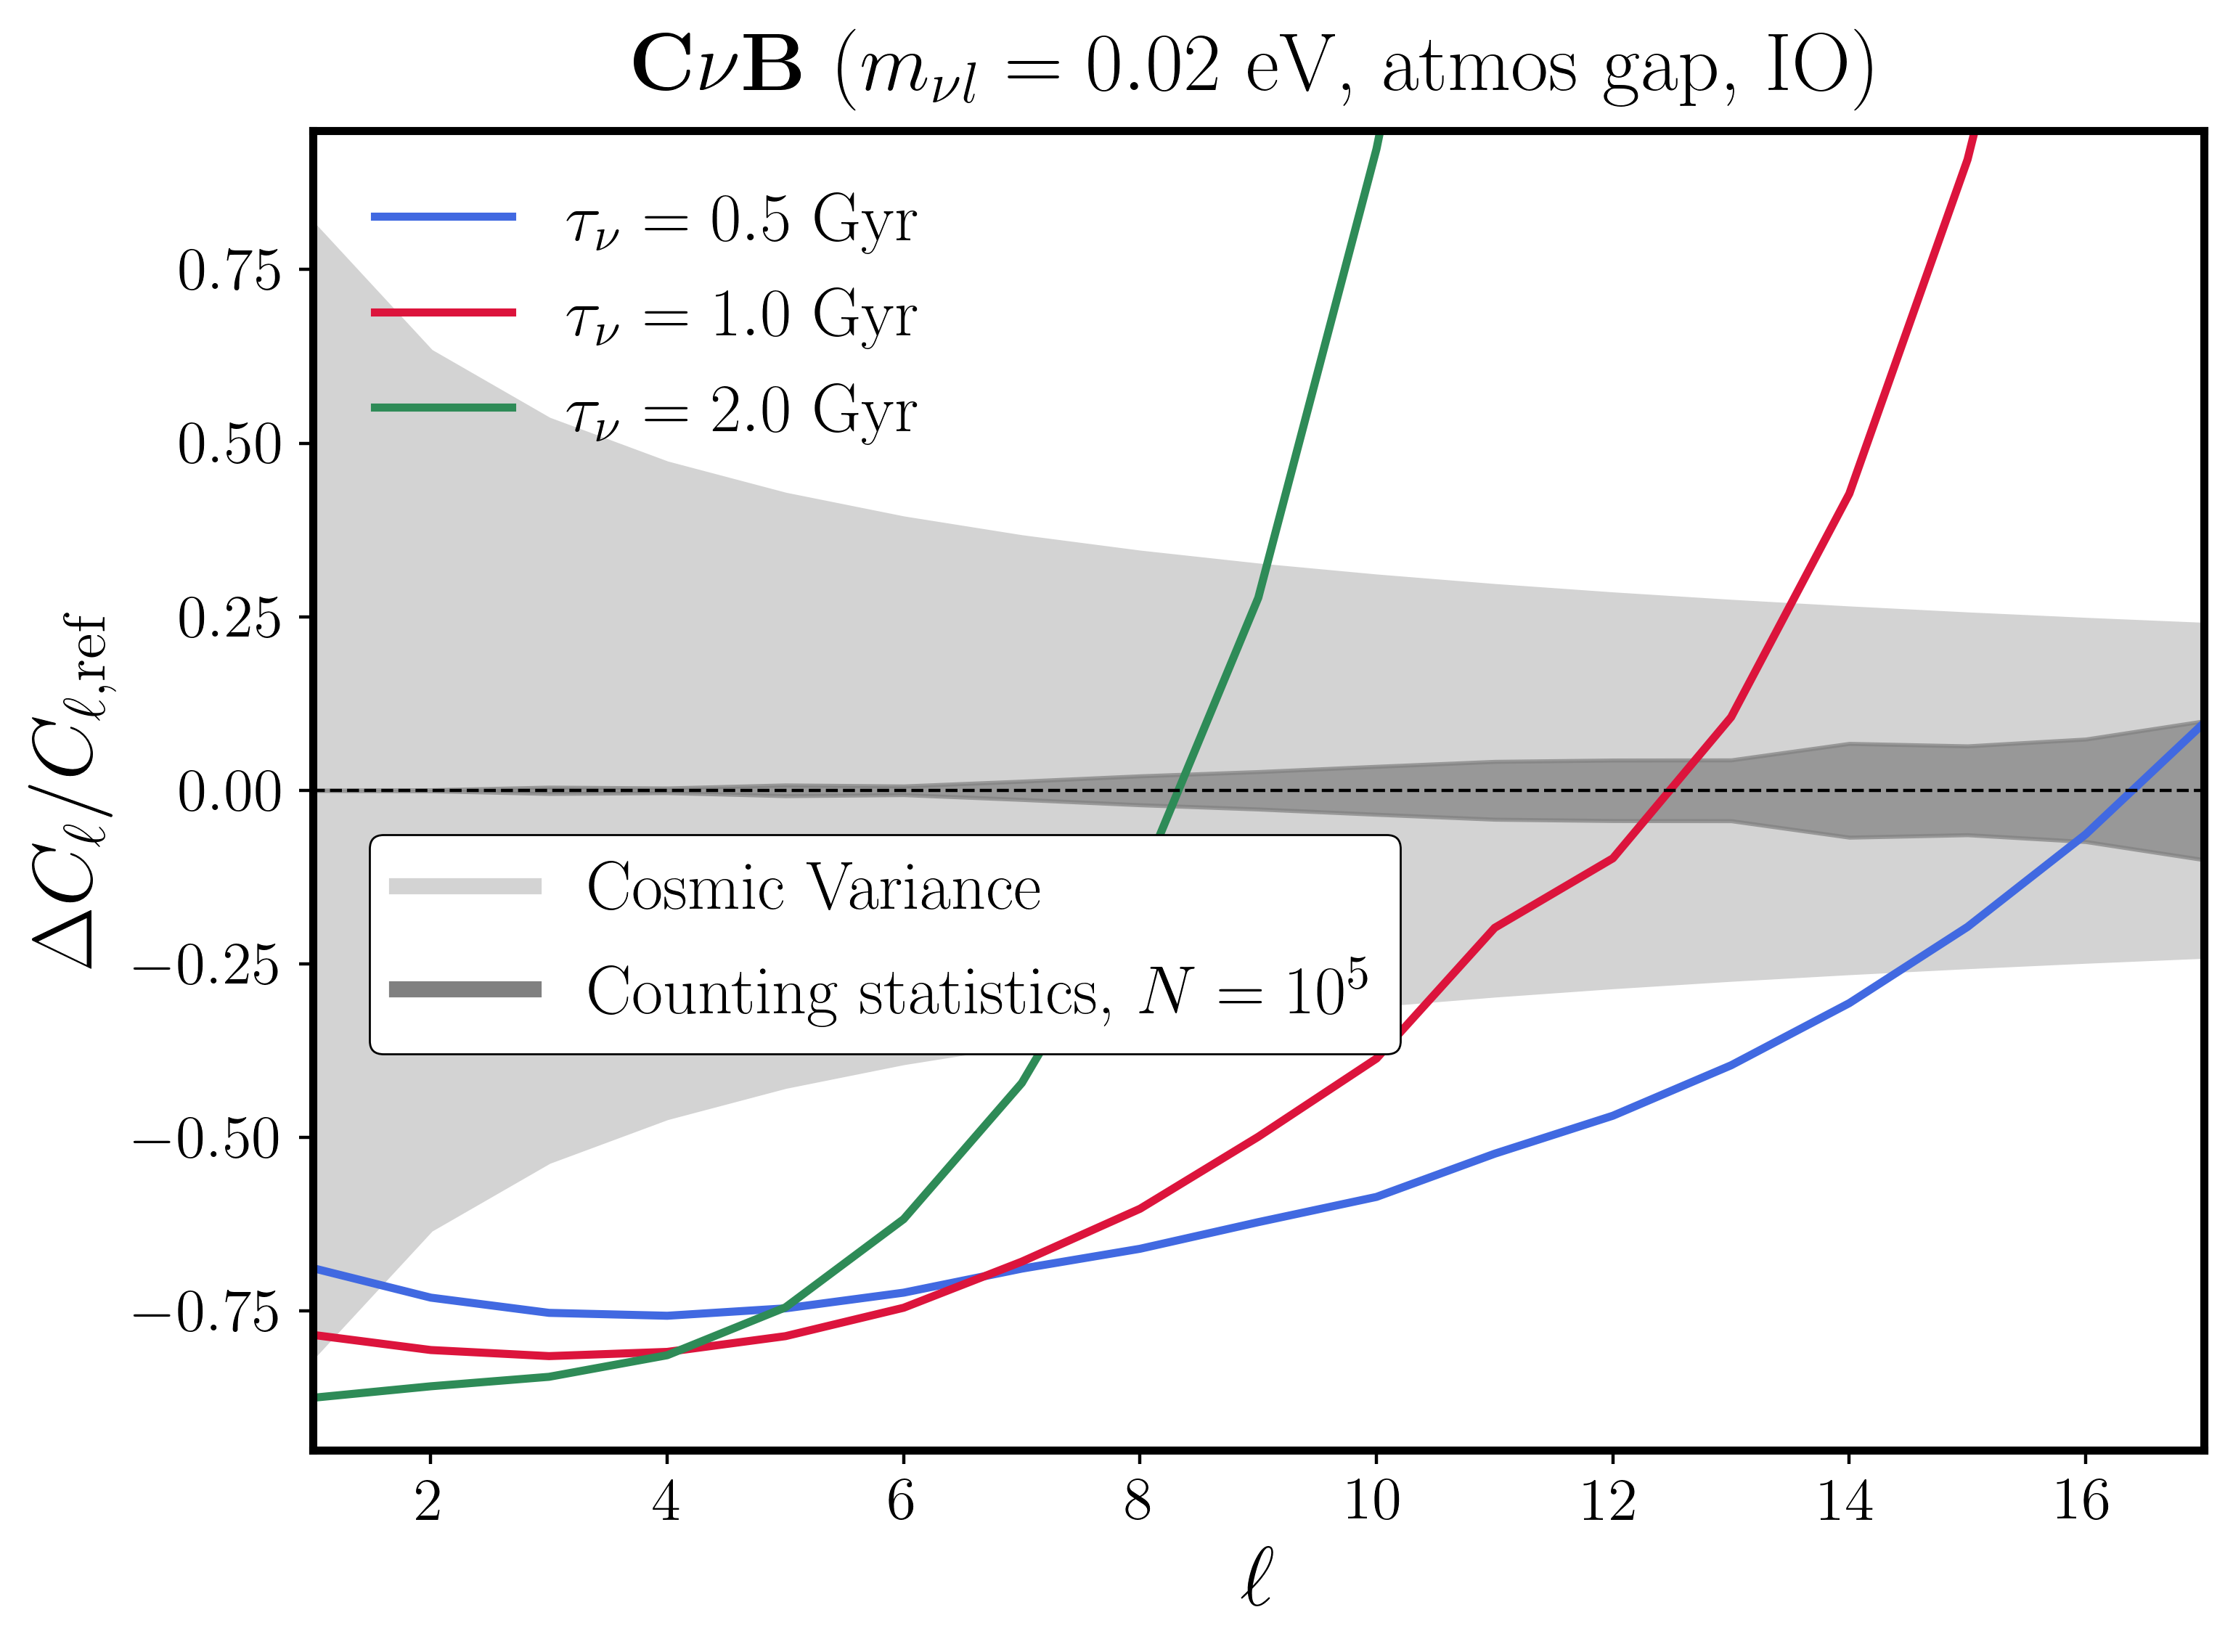

In [46]:
plt.figure(figsize=(8, 6.), dpi=400)

l_high = 18
ell = np.arange(1, l_high)

res1_smooth = savgol_filter((Cl_avg1[1:]-Cl_avg0[1:])/Cl_avg0[1:], 11, 3)
res2_smooth = savgol_filter((Cl_avg2[1:]-Cl_avg0[1:])/Cl_avg0[1:], 11, 3)
res3_smooth = savgol_filter((Cl_avg3[1:]-Cl_avg0[1:])/Cl_avg0[1:], 11, 3)


plt.plot(ell,res3_smooth,color='royalblue', linewidth=2.0,label=r"$\tau_\nu = 0.5 \ \mathrm{Gyr}$")
plt.plot(ell,res1_smooth,color='crimson',   linewidth=2.0,label=r"$\tau_\nu = 1.0 \ \mathrm{Gyr}$")
plt.plot(ell,res2_smooth,color='seagreen' , linewidth=2.0,label=r"$\tau_\nu = 2.0 \ \mathrm{Gyr}$")


#plt.plot(ell,(Cl_avg3[1:]-Cl_avg0[1:])/Cl_avg0[1:],color='blue',linewidth=1.5,label=r"$\tau_\nu = 0.5 \ \mathrm{Gyr}$")
#plt.plot(ell,(Cl_avg1[1:]-Cl_avg0[1:])/Cl_avg0[1:],color='red', linewidth=1.5,label=r"$\tau_\nu = 1.0 \ \mathrm{Gyr}$")
#plt.plot(ell,(Cl_avg2[1:]-Cl_avg0[1:])/Cl_avg0[1:],color='green' , linewidth=1.5,label=r"$\tau_\nu = 2.0 \ \mathrm{Gyr}$")

plt.fill_between(ell, -np.sqrt(2./(2*ell+1.)), +np.sqrt(2./(2*ell+1.)), color='lightgray')

plt.fill_between(ell, -cl_std/Cl_avg0[1:], cl_std/Cl_avg0[1:], alpha=0.7, color='gray') 


plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

plt.yscale('linear')
plt.xscale('linear')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_{\ell} / C_{\ell, \mathrm{ref}}$')

plt.title(r"{\bf{C$\nu$B}} ($m_{\nu l} = %.2f$ eV, atmos gap, IO)"%m_nuL,pad=10)

plt.xlim(1, 17)
plt.ylim(-0.95, 0.95)
plt.tight_layout()
plt.grid(False)

legend1 = plt.legend(frameon=False, loc='upper left')
ax = plt.gca()
ax.add_artist(legend1)

[x.set_linewidth(2.0) for x in plt.gca().spines.values()]

lines = [Line2D([0], [0], color='lightgray', linewidth=4, linestyle='-'),
         Line2D([0], [0], color='gray', linewidth=4, linestyle='-')]
labels = [r'Cosmic Variance',r'Counting statistics, $N=10^5$']
legend2 = plt.legend(lines, labels,loc=(0.03,0.3),frameon=True, 
           facecolor='white',edgecolor='black',framealpha=1.0)
legend2.get_frame().set_linewidth(0.5)

plt.savefig('plots_residuals/CNB_residuals_B2.pdf')

plt.show()